# Buck Converter Design
**Author:** Ian Eykamp, **Date:** June 15, 2023

### Goals
To design a buck converter which can take in a large range of input voltages and output a controllable current to a battery. It should be robust to different input voltages and different battery models.

I chose some made-up parameters which I will replace once I am ready to design the real PCB. For example, I gave the battery a nominal voltage of 12V with a 0.1Ω internal resistance. This will be updated once I do some testing / read the datasheet on the batteries. Also, I did not worry about choosing resistor and capacitor values which exist in real life. This simulation is just to prove the concept that I can create a buck converter with a working control loop.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_db(gain):
    return np.log10(np.abs(gain)) * 20

def to_decibels(gain):
    return to_db(gain)

def from_db(db):
    return 10 ** (db / 20)

Using matplotlib backend: TkAgg


# Schematic

The buck converter follows the one we developed in class. The new features are a battery model in place of a load resistor and a current-sensing control loop instead of an output voltage control loop.

The battery model consists of a 12V nominal voltage source in series with a 0.1Ω resistor. This is based on what Beat told me to do. I might be able to replace it with a more accurate battery model, but I do not know if I need to. At least, I will perform measurements or read the datasheet to find the parameters of the real battery I will be using.

The current control loop consists of a shunt resistor in series with the battery straddled by a differential amplifier. The diff amp acts like a voltmeter since it finds the voltage drop across the resistor. I want a nominal 20A charging rate, so I chose a shunt resistance value of 5mΩ. That means a 20A current will create a 0.1V drop across the shunt resistor. The diff amp's value is fed into an op-amp configured as a non-inverting amplifier with a gain of 25. Thus the 0.1V drop will become a 2.5V signal. This is the signal that is fed into the UC2844 and the compensator.

There is one more step, which is a voltage adder connected to an analog pin coming from an Arduino. This voltage is added to the amplified current-sensing signal, such that the output will reach 2.5V at a lower voltage. It turns out that the control loop obeys this voltage adder and works to make the output current equal to $20A \cdot (1 - \frac{V_{control}}{2.5V})$, where $V_{control}$ is the analog voltage created by the Arduino. I am probably going to implement this voltage adder using the same op amp as I will use for the gain.

![Overall Schematic](plecs_data/schematic_buck_converter2.png)

### Define measured constants and nominal values
I aimed for nominally operating very close to boundary condition mode (BCM), but slightly in CCM. Since it is operating with a large amount of current, I thought it was a good balance between energy stored in the inductor and allowing current to flow continuously into the battery (reducing ripple).

In [34]:
Cout = 100 * units.microfarad
Fs = 50 * units.kilohertz
Ts = 1 / Fs
Ibat = 20 * units.amp
Rbat = 0.1 * units.ohm
Vg_nominal = 40 * units.volt
Vbat_nominal = 12 * units.volt + Ibat * Rbat
Rbat = 0.1 * units.ohm
Vout_nominal = Vbat_nominal + Ibat * Rbat
D_nominal = Vout_nominal / Vg_nominal
Imin = 2 * units.amp
L = Vout_nominal / (2 * (Ibat - Imin)) * (1 - D_nominal) * Ts

print(f"D = {np.round(D_nominal, 2)}")
print(f"L = {L.to_compact(units.henry)}")
print(f"Vout = {Vout_nominal.to_compact(units.volt)}")

D = 0.40
L = 5.33 µH
Vout = 16.00 V


### Plant Frequency Analysis
Ok, so here's where I took a shortcut. Before doing any frequency analysis or compensator design in class, we went through a whole derivation of the large-signal and small-signal models for the buck-boost converter and came up with a theoretical prediction of what the plant transfer function would look like. I tried to comprehend the latter half of Chapter 12 in *Fundamentals of Power Electronics*, but I got lost in all the math and could not reproduce this derivation for the buck converter. I found Table 12.3 in that textbook which listed the simple model transfer function as being $\frac{\hat{v}}{\hat{i_c}} = \frac{R}{1 + sRC}$, where $\frac{\hat{v}}{\hat{i_c}} \stackrel{?}{=} G_p$ is presumably the transfer function I am looking for and $R$ is the load resistance and $C$ is the load capacitance. Simple enough! I hope it's right.

With that in hand, I went into PLECS and made a bode plot of the plant transfer function just like we did with the physical hardware in Lab 9. Below, I plotted the simulated results of the multitone analysis. Apart from a relatively large constant offset, it matches the textbook equation pretty well.

![Plant Frequency Analysis Schematic](plecs_data/schematic_9a.png)

Lead element center voltage (ω_c): 6.25 kHz


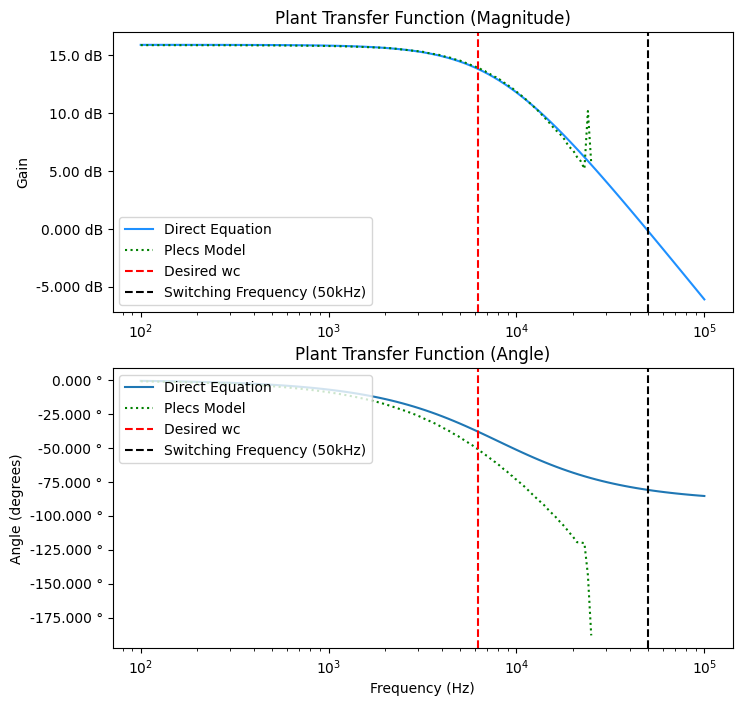

In [35]:
df_plant = pd.read_csv("plecs_data/plant_bode.csv")
df_plant.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

expected_wc = 50e3 / 8 # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")
w = np.logspace(2, 5, 100) # * units.hertz

R_Iout_shunt = 5e-3 # * units.ohm
Rload = 0.1 # * units.ohm
Cload = 200e-6 # * units.farad
mystery_factor = 50 # for a total of * 62.5 = 5^4 / 10 = 5^3 / 2
theoretical_plant_bode = Rload / (1 + (2 * np.pi * 1j * w) * Rload * Cload) / Rload * R_Iout_shunt * 25 * mystery_factor

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Plant Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_plant_bode), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_plant["w"], df_plant["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Plant Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_plant_bode, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_plant["w"], df_plant["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

Ok, so the PLECS model matches the theory pretty well. You will notice that the magnitude plot matches almost exactly, but I said they were off by a significant factor. What I've shown in the graph above is after multiplying the theoretical curve by a magical factor of 50 to make them line up.

```
mystery_factor = 50
theoretical_plant_bode = Rload / (1 + (2 * np.pi * 1j * w) * Rload * Cload) / Rload * R_Iout_shunt * 25 * mystery_factor
```

More clarification on the above line of code: `Rload / (1 + (2 * np.pi * 1j * w) * Rload * Cload)` This is the equation given in the textbook as $\frac{R}{1 + sRC}$, with some terms to convert from real-valued `w` in Hertz to complex-valued $s$ in radians per second. But this equation is designed to capture the transfer function from $I_{peak}$ to $V_{out}$, and I want from $V_{COMP}$ to $V_{FB}$. To convert $V_{out}$ into $V_{FB}$, I use `/ Rload` to convert output voltage into to current (assuming the equation was designed for a regular load resistor, not a battery model), `* R_Iout_shunt` to convert the current into the voltage seen by the diff amp, and `* 25` for the amplifier. There is still a mystery factor of `* mystery_factor`, which I assume originates from the conversion of $V_{COMP}$ through the innards of the UC2844 and into $I_{peak}$.

There is obviously some second order behaviour going on above a couple of kHz, especially for the angle, but I'm hoping I can just ignore that.

### Finding the compensator values
**Using code copied from Lab 11**

Design parameters are a gain cross-over frequency at 6.25kHz, gain factor of -13dB to make the gain crossover occur at that frequency (obtained from the simulated transfer function above), and phase boost of 30 degrees. I used a Type II compensator consisting of an integrating pole and a lead element like we used in class for the buck-boost converter.

In [36]:
class Compensator:
    def __init__(self, Rf1_unitless):
        self.Rf1 = Rf1_unitless * units.ohm
        self.find_values()

    def __repr__(self) -> str:
        return f"K: {self.K},\t Gc0: {self.Gc0.to_compact()},\t Rf1: {self.Rf1.to_compact(units.ohm)},\t Rc1: {self.Rc1.to_compact(units.ohm)},\t Cc1: {self.Cc1.to_compact(units.farad)},  \t Cc2: {self.Cc2.to_compact(units.farad)}"

    def find_values(self):
        self.wc = 50 * units.kilohertz * units.revolutions / 8

        self.angle_boost = 30 * units.degree
        self.K = np.tan((self.angle_boost / 2 + 45 * units.degree))
        self.Kp = 1 / from_db(13) # from_db(32)
        self.wz = self.wc / self.K
        self.wp = self.wc * self.K
        self.Gc0 = self.Kp * self.wc * np.sqrt((1 + self.K ** (-2)) / (1 + self.K ** 2))
        self.Cc1 = 1 / (self.Gc0 * self.Rf1)
        self.Rc1 = 1 / (self.wz * self.Cc1)
        self.Cc2 = 1 / (self.wp * self.Rc1)

for R in [2, 2.2, 2.7, 3.3, 3.9, 4.3, 4.7, 5.1, 5.6, 6.2, 6.8, 7.5, 8.2, 10]: # values to try in kiloohms
    R_to_highlight = 5.6
    if R == R_to_highlight:
        print() # highlight the chosen value
    compensator = Compensator(R * 1e3)
    print(compensator)
    if R == R_to_highlight:
        print()

K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 2.00 kΩ,	 Rc1: 447.74 Ω,	 Cc1: 98.51 nF,  	 Cc2: 32.84 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 2.20 kΩ,	 Rc1: 492.52 Ω,	 Cc1: 89.55 nF,  	 Cc2: 29.85 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 2.70 kΩ,	 Rc1: 604.45 Ω,	 Cc1: 72.97 nF,  	 Cc2: 24.32 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 3.30 kΩ,	 Rc1: 738.78 Ω,	 Cc1: 59.70 nF,  	 Cc2: 19.90 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 3.90 kΩ,	 Rc1: 873.10 Ω,	 Cc1: 50.52 nF,  	 Cc2: 16.84 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 4.30 kΩ,	 Rc1: 962.65 Ω,	 Cc1: 45.82 nF,  	 Cc2: 15.27 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 4.70 kΩ,	 Rc1: 1.05 kΩ,	 Cc1: 41.92 nF,  	 Cc2: 13.97 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 5.10 kΩ,	 Rc1: 1.14 kΩ,	 Cc1: 38.63 nF,  	 Cc2: 12.88 nF

K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 5.60 kΩ,	 Rc1: 1.25 kΩ,	 Cc1: 35.18 nF,  	 Cc2: 11.73 nF

K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 6.20 kΩ,	 Rc1: 1.39 kΩ,	 Cc1: 31.78 nF,  	 Cc2: 10.59 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 6.80 kΩ,	 Rc1: 

### Compensator Transfer Function

The values I chose for the compensator are shown in the schematic below. These will change when I update the model parameters for my final design, but the behavior of the compensator should remain the same.

![Compensator Schematic](plecs_data/schematic_compensator.png)

I ran the frequency analysis in PLECS to determine the transfer function, as well as writing down the equation based on the components. They match exactly.

Lead element center voltage (ω_c): 6.25 kHz


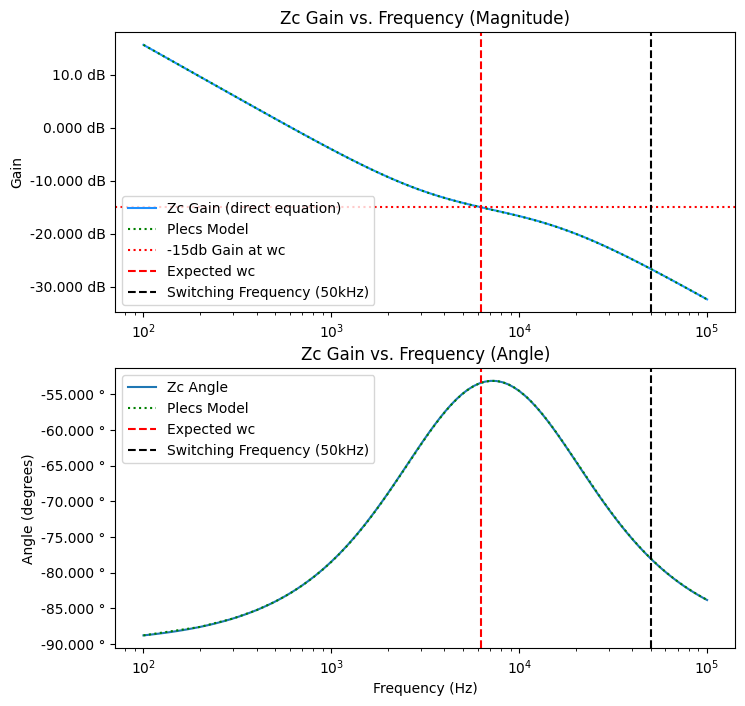

In [37]:
df_compensator = pd.read_csv("plecs_data/compensator_bode.csv")
df_compensator.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

# chosen values
compensator = Compensator(5.6 * 1e3)
Rf1 = compensator.Rf1.to(units.ohm).magnitude
Rc1 = compensator.Rc1.to(units.ohm).magnitude
Cc1 = compensator.Cc1.to(units.farad).magnitude
Cc2 = compensator.Cc2.to(units.farad).magnitude
expected_wc = 1 / (Rc1 * np.sqrt(Cc1 * Cc2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

w = np.logspace(2, 5, 100) # * units.hertz
def get_Zc(my_w):
    my_Zc = 1 / (1 / (Rc1 + 1 / (2 * np.pi * 1j * my_w * Cc1)) + 1 / (1 / (2 * np.pi * 1j * my_w * Cc2))) / Rf1 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", color = "dodgerblue", label = "Zc Gain (direct equation)")
ax1.semilogx(df_compensator["w"], df_compensator["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = -15, linestyle = "dotted", color = "red", label = "-15db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Zc Gain vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(df_compensator["w"], df_compensator["CH2"] + 180, linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

### Open-Loop Transfer Function
![Open-Loop Schematic](plecs_data/schematic_10a.png)

I implemented the compensator in PLECS and ran open-loop and closed-loop frequency analyses, copying the Analog Discovery (AD2) model from Lab 10. Lo and behold, it does the things we want, including infinite open-loop gain at DC, a crossover frequency where we wanted it, and an excellent phase margin between 70 and 90 degrees, depending on if you're looking at the PLECS results or the theoretical equation.

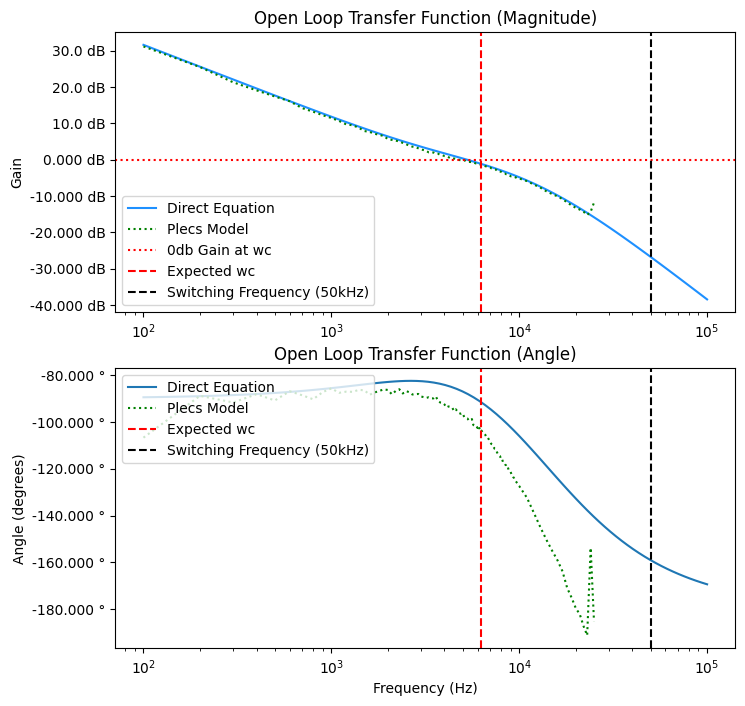

In [38]:
df_open_loop = pd.read_csv("plecs_data/open_loop_bode.csv")
df_open_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_open_loop = theoretical_plant_bode * Zc

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Open Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_open_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_open_loop["w"], df_open_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = 0, linestyle = "dotted", color = "red", label = "0db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Open Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_open_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_open_loop["w"], df_open_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

### Closed-Loop Transfer Function
![Closed-Loop Schematic](plecs_data/schematic_10b.png)

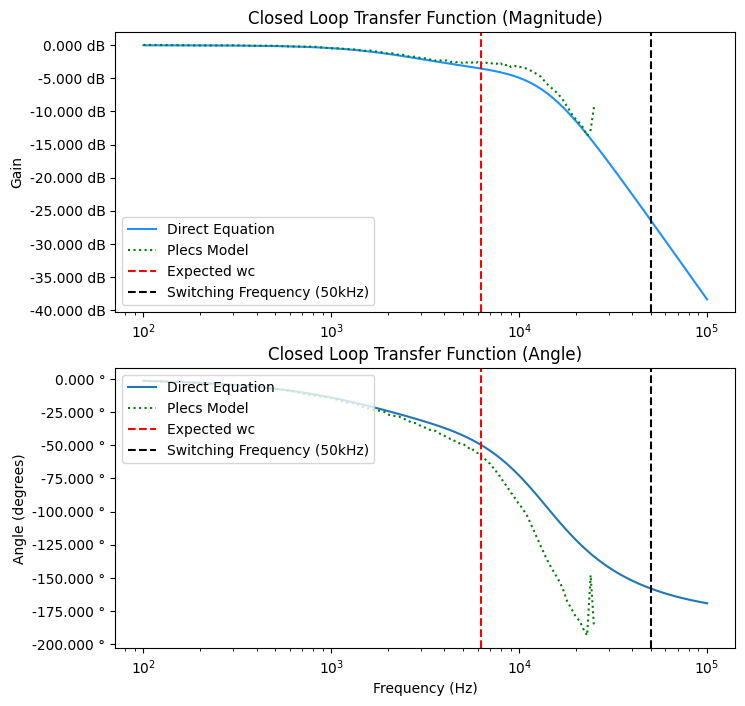

In [39]:
df_closed_loop = pd.read_csv("plecs_data/closed_loop_bode.csv")
df_closed_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_closed_loop = theoretical_open_loop / (1 + theoretical_open_loop)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Closed Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_closed_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_closed_loop["w"], df_closed_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Closed Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_closed_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_closed_loop["w"], df_closed_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

Again, the theory and the PLECS model match pretty well. The system has a gain of 1 at DC and strong attenuation well before the switching frequency, exactly as we want.

### Time Response
Lastly, I implemented a square wave signal to the voltage adder to simulate a change in the desired current.

![Closed-Loop Schematic](plecs_data/schematic_buck_converter_square_wave.png)


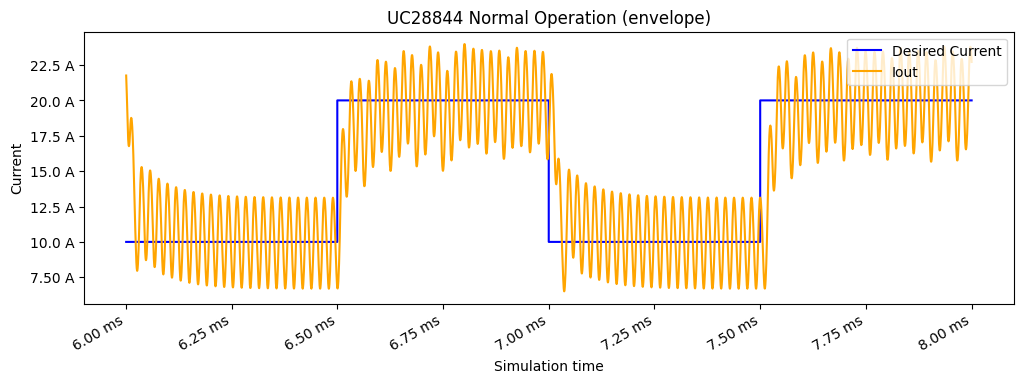

In [64]:
df = pd.read_csv("plecs_data/square_wave_response.csv")
df.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df["Iexpected"] = 20 * (1 - df["Pulse Generator"] / 2.5)
df_zoom = df.loc[(df["Time / s"] > 6e-3) & (df["Time / s"] < 8e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
ax1.plot(df_zoom["Time / s"], df_zoom["Iexpected"], color = "blue", label = "Desired Current")
ax1.plot(df_zoom["Time / s"], df_zoom["Iout"], color = "orange", label = "Iout")
helper.axes_labels("Simulation time", "s", "Current", "A", title = "UC28844 Normal Operation (envelope)", ax = ax1)
ax1.legend(loc = "upper right")

There is significant ripple in the output current, but the average value approaches the set point very quickly. The system appears slightly underdamped, since there is no overshoot, but it still settles within a quarter of a millisecond, which is fast enough for me. The ripple can be significantly reduced by increasing the load capacitance, say from 100uF to 200uF, although this would likely change the plant transfer function and necessitate recalculating the compensator values.

### Next Steps
If this design looks good to you, I will start refining the parameter values, such as the input voltage, desired current, and battery model. With the updated parameters, I will re-run the simulation and make sure it behaves as I expect. Then I will probably start speccing physical components and designing a PCB in KiCAD.